# Data

In [3]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
from scipy import stats
from statsmodels import regression
import statsmodels.formula.api as sm
from numba import jit, njit, prange, float64, int64
import os
import glob
from datetime import datetime, timedelta, date
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

##utiles pour GARCH
from random import gauss
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from arch.__future__ import reindexing


In [4]:
def simulategarchdata(T, omega, alpha1,alpha2, beta1, beta2):
    n = T

    test_size = int(n*0.1)

    series = [gauss(0,1), gauss(0,1)]
    vols = [1, 1]

    for _ in range(n):
        new_vol = np.sqrt(omega + alpha_1*series[-1]**2 + alpha_2*series[-2]**2 + beta_1*vols[-1]**2 + beta_2*vols[-2]**2)
        new_val = gauss(0,1) * new_vol

        vols.append(new_vol)
        series.append(new_val)
    return [vols,series]

## rt est donné par simulateagarchdata[10]

In [5]:
# Set kbar
kbar = 4

# Simulated data, 60% in-sample for estimation, 40% out-of-sample for forecasts.  See Section 4 re rationale for simulated data
b = 6
m0 = 1.6
gamma_kbar = 0.8
sig = 2/np.sqrt(252)    

dat1=pd.read_csv("DEXJPUS_calvet.csv")



# DEXJPUS, 60% in-sample for estimation, 40% out-of-sample for forecasts
dat2 = pd.read_csv("DEXJPUS_calvet.csv")    #on récupère les données du fichier CSV
T = len(dat2)

E = np.rint(0.6*T).astype(int) 

##dat1 = simulatedata(b,m0,gamma_kbar,sig,kbar,T)
##dat1E = dat1[0:E,]
##dat1F = dat1[E:,]

test_size=T//10
dat2 = dat2.loc[dat2.DEXJPUS != "."].DEXJPUS.astype(float) #on ne garde que la colonne DEXJPUS (pas la colonne des dates)
dat2 = np.array(dat2) 
print("dat2")
print(dat2)
dat2_rtn = dat2[0:-1]#on enlève le dernier élément       #ca a l'air inutile
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1]) # liste des log-return
dat2 = dat2[dat2 != 0]
dat2 = dat2[:,np.newaxis]#rajoute une dimension au vecteur
dat2E = dat2[0:E,]
dat2F = dat2[E:,]




##dat1E.shape, dat1F.shape, 
dat2E.shape, dat2F.shape


dat2
[264.06 262.88 262.88 ... 119.83 119.38 119.85]


((4552, 1), (2535, 1))

# Stats

In [6]:
##j = stats.describe(dat1)
##print("Descriptive statistics for Simulated Data: ","\n"
  ##    "Number of observations = ",j.nobs,"\n"
    ##  "Minimum, Maximum = ",str(j.minmax),"\n"
      #"Mean = %.5f" %  j.mean,"\n"
 #     "Variance = %.5f" %  j.variance,"\n"
  #    "Standard deviation = %.5f" %  j.variance**0.5,"\n"
   #   "Skewness = %.5f" %  j.skewness,"\n"
    #  "Kurtosis = %.5f" %  j.kurtosis, "\n")

k = stats.describe(dat2)
print("Descriptive statistics for DEXJPUS 1971-2022: ","\n"
      "Number of observations = ",k.nobs,"\n"
      "Minimum, Maximum = ",str(k.minmax),"\n"
      "Mean = %.5f" %  k.mean,"\n"
      "Variance = %.5f" %  k.variance,"\n"
      "Standard deviation = %.5f" %  k.variance**0.5,"\n"
      "Skewness = %.5f" %  k.skewness,"\n"
      "Kurtosis = %.5f" %  k.kurtosis, "\n")



Descriptive statistics for DEXJPUS 1971-2022:  
Number of observations =  7087 
Minimum, Maximum =  (array([-0.05630211]), array([0.06255581])) 
Mean = -0.00011 
Variance = 0.00004 
Standard deviation = 0.00666 
Skewness = -0.38715 
Kurtosis = 5.46706 



# Time series analysis

In [7]:
sns.set(style="ticks", palette="muted")

### tracer corrélation des données du marché, l'histogramme et les quantiles
### les acf tracent tmp_data et non pas tmp_data**2 contrairement au modèle GARCH


def tsdisplay(y, figsize = (16,9), title = "", color = ""):
    tmp_data = pd.Series(y)
    print(tmp_data)
    fig = plt.figure(figsize = figsize)
    # Plot time series
    tmp_data.plot(ax = fig.add_subplot(311), title = "$Log\ returns\ time\ series:\ " + title + "$", legend = False, color=color, linewidth=0.5, alpha=0.75)
    # Plot ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = 20, zero = False, color=color, ax = fig.add_subplot(323))
    # Plot PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = 20, zero = False, color=color, ax = fig.add_subplot(324), method="ywm")
    plt.axis([0,25,-0.05,0.25])
    # QQ plot of the data:
    sm.qqplot(tmp_data, line='s', color=color, ax = fig.add_subplot(325)) 
    plt.title("Q-Q Plot")
    # Plot residual histogram:
    fig.add_subplot(326).hist(tmp_data, color=color, bins = 120)
    plt.title("Histogram")
    # Fix layout of the plots:
    plt.tight_layout()
    


Text(0.5, 1.0, 'DEXJPUS 1973-2002')

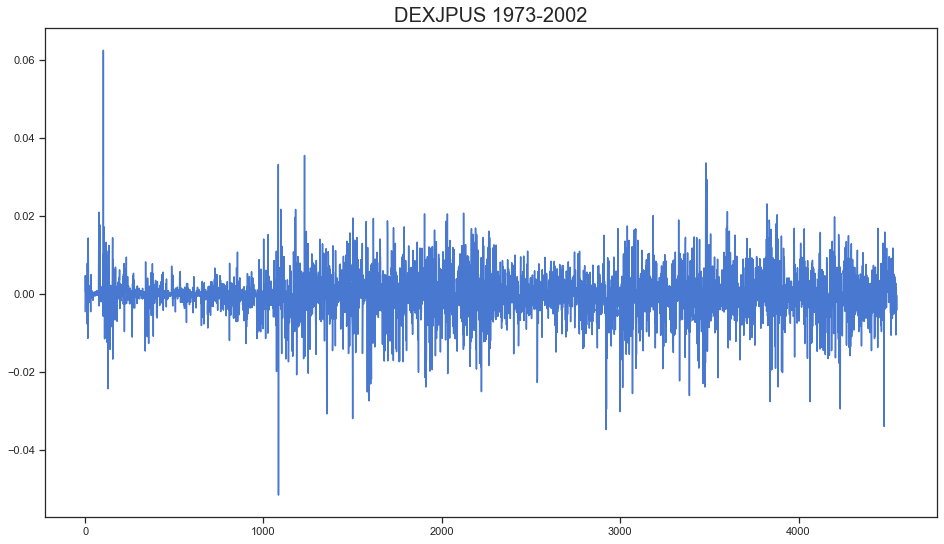

In [8]:
## affichage des log-returns des données du marché

series=dat2E
fig_garch=plt.figure(figsize=(16,9))
plt.plot(series)
plt.title('DEXJPUS 1973-2002', fontsize=20)


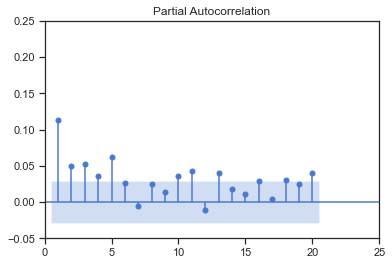

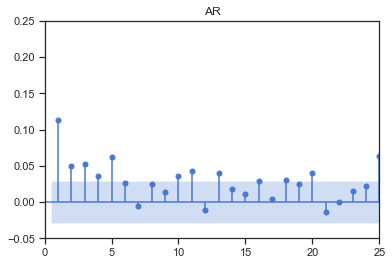

In [9]:
plot_pacf(np.array(series)**2,lags=20, method="ywm") ##termes au carré
plt.axis([0,25,-0.05,0.25])
plot_pacf(np.array(series)**2, title="AR", method="ywm")
plt.axis([0,25,-0.05,0.25])

plt.show()

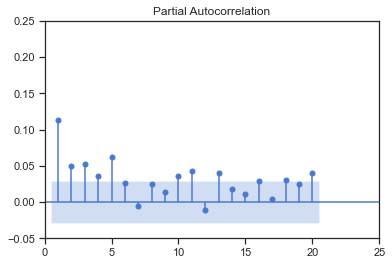

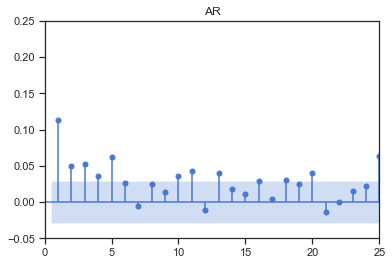

In [10]:
plot_pacf(np.array(series)**2,lags=20, method="ywm") ##termes au carré
plt.axis([0,25,-0.05,0.25])
plot_pacf(np.array(series)**2, title="AR", method="ywm")
plt.axis([0,25,-0.05,0.25])

plt.show()

In [15]:
train, test = series[:-test_size], series[-test_size:]
model = arch_model(train, p=2, q=2, rescale=False)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1166921206916890.2
Iteration:      2,   Func. Count:     23,   Neg. LLF: -14342.31947782774
Optimization terminated successfully    (Exit mode 0)
            Current function value: -14342.319471478335
            Iterations: 6
            Function evaluations: 23
            Gradient evaluations: 2


TypeError: 'ARCHModelResult' object is not subscriptable

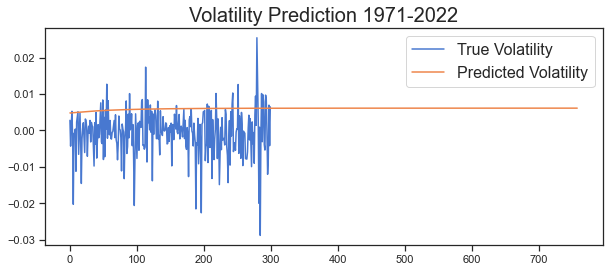

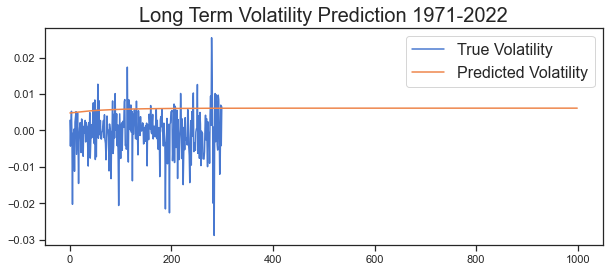

In [12]:
## prédictions du modèle Garch(2,2)

predictions = model_fit.forecast(horizon=test_size)

## prediction à court terme

plt.figure(figsize=(10,4))
true, = plt.plot(dat2F[:300]) #afficher la volatilité réelle
preds, = plt.plot(np.sqrt(predictions.variance.values[-1, :]))
plt.title('Volatility Prediction 1971-2022', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

## prediction à long terme
predictions_long_term = model_fit.forecast(horizon=1000)
plt.figure(figsize=(10,4))
true, = plt.plot(dat2F[:300]) #afficher la volatilité réelle
preds, = plt.plot(np.sqrt(predictions_long_term.variance.values[-1, :]))
plt.title('Long Term Volatility Prediction 1971-2022', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

0      -0.004479
1       0.004744
2       0.000530
3       0.000530
4       0.001058
          ...   
7082    0.000412
7083    0.005099
7084   -0.017127
7085   -0.003762
7086    0.003929
Length: 7087, dtype: float64


C:\Users\hp\miniconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2823529411764706, 0.47058823529411764, 0.8156862745098039, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


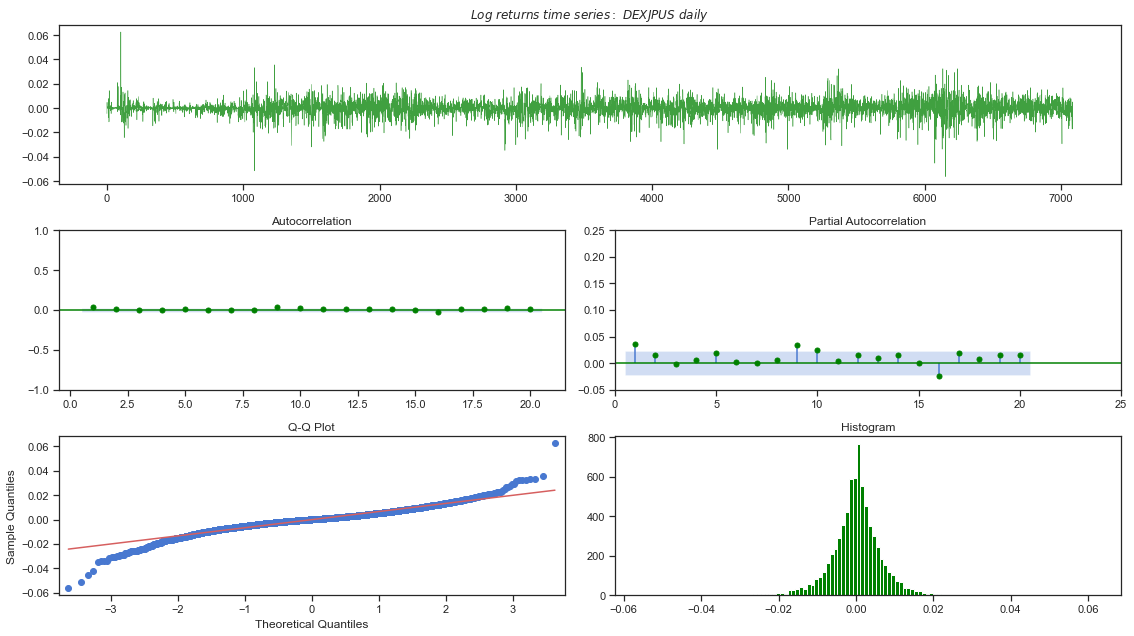

In [13]:
s = np.array(dat2).astype(float)
s = s[s != 0].copy()




tsdisplay(s, title = "DEXJPUS\ daily", color='green')


0      -0.004479
1       0.004744
2       0.000530
3       0.000530
4       0.001058
          ...   
7082    0.000412
7083    0.005099
7084   -0.017127
7085   -0.003762
7086    0.003929
Length: 7087, dtype: float64


C:\Users\hp\miniconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2823529411764706, 0.47058823529411764, 0.8156862745098039, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


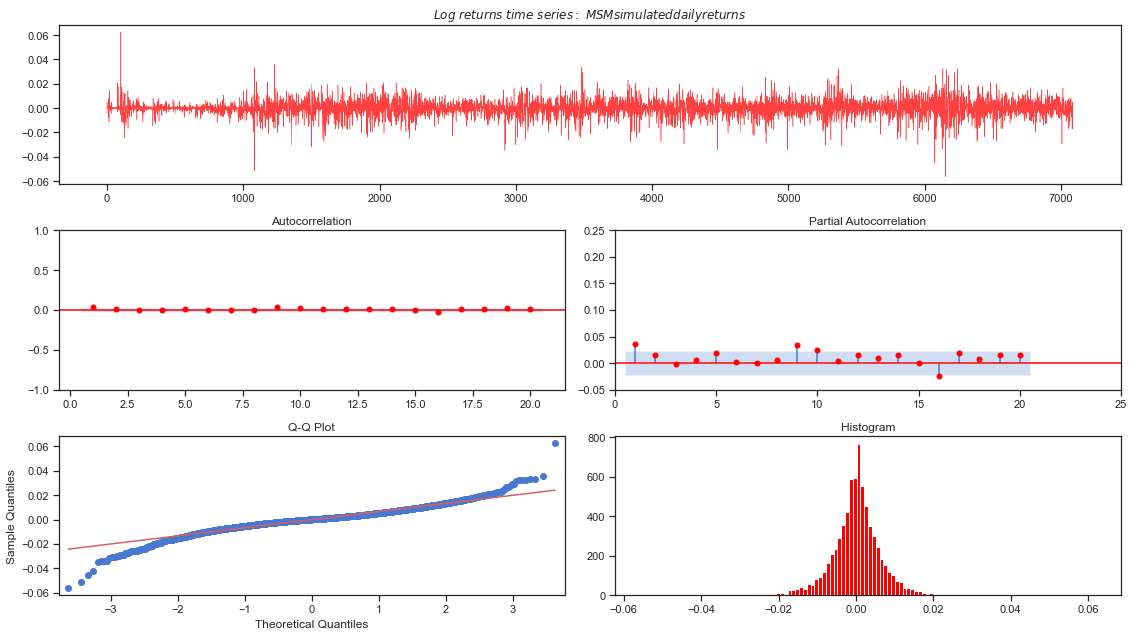

In [14]:
s = np.array(dat2).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "MSM simulated daily returns", color='red')